In [14]:
# chargement des extensions
%reload_ext autoreload
%autoreload 2

# import des librairies
from MODULES.loader import IntermovieDataLoader
import pandas as pd
import numpy as np

In [5]:
# Supprimer à l'import
title_ratings = pd.read_csv(DATASET_PATH + "title.ratings.tsv", sep='\t', index_col='tconst', encoding='utf-8')
title_akas = pd.read_csv(DATASET_PATH + "title.akas.tsv", sep='\t', index_col='titleId', usecols=['titleId', 'title', 'region', 'isOriginalTitle'], encoding='utf-8')
title_akas = title_akas.dropna()

In [11]:
DATASET_PATH = 'DATAS/movies_dataset/'
CURATED_PATH = 'DATAS/CURATED/'
WORKS = 'WORKS/'
FORMATS = 'FORMATS/'
REGIONS = 'REGIONS/'
MOVIES_GENRES = 'MOVIES_GENRES/'
nb_votes = 500

data_loader = IntermovieDataLoader()
# data_loader.split_data_role()
# data_loader.split_data_type()
# data_loader.split_data_origine()
# data_loader.split_data_genres()

## Création du dataset avec les régions originales :

In [6]:
title_akas = title_akas.replace('\\N', np.nan)
original_titles = title_akas[title_akas.isOriginalTitle==1]['title'].to_frame()
original_titles = original_titles.merge(title_akas[['title', 'region']], how="left", right_on=['titleId', 'title'], left_on=['titleId', 'title'])
original_titles = original_titles.dropna()
original_titles = original_titles.reset_index().drop_duplicates(subset="titleId", keep = "first").set_index('titleId')

# Export en CSV :
# original_titles.to_csv(CURATED_PATH + 'original_titles_regions.csv')


## Création du dataset Global

In [7]:
actors = pd.concat([pd.read_csv(CURATED_PATH + WORKS + 'actor.csv', delimiter=',', usecols=['tconst', 'nconst'], index_col = ['tconst']), pd.read_csv(CURATED_PATH + WORKS + 'actress.csv', delimiter=',', usecols=['tconst', 'nconst'], index_col = ['tconst'])])
actors = actors.rename(columns={"nconst": "actors"})

movies = pd.read_csv(CURATED_PATH + FORMATS + 'movie.csv', delimiter=',', usecols=['tconst', 'isAdult', 'startYear', 'runtimeMinutes', 'genres'], index_col = ['tconst'])
movies = movies[movies.runtimeMinutes != '\\N'][movies.genres != '\\N']

dataset = actors.merge(movies, how='right', left_index=True, right_index=True)
dataset = dataset.dropna()
dataset = dataset.assign(genres=dataset['genres'].str.split(',')).explode('genres')

In [8]:
producers = pd.read_csv(CURATED_PATH + WORKS + 'producer.csv', delimiter=',', usecols=['tconst', 'nconst'], index_col = ['tconst'])
producers = producers.rename(columns={"nconst": "producer"})

writers = pd.read_csv(CURATED_PATH + WORKS + 'writer.csv', delimiter=',', usecols=['tconst', 'nconst'], index_col = ['tconst'])
writers = writers.rename(columns={"nconst": "writer"})

composers = pd.read_csv(CURATED_PATH + WORKS + 'composer.csv', delimiter=',', usecols=['tconst', 'nconst'], index_col = ['tconst'])
composers = composers.rename(columns={"nconst": "composer"})

producers = producers.merge(writers, how="inner", left_index=True, right_index=True)
producers = producers.merge(composers, how="inner", left_index=True, right_index=True)
dataset = dataset.merge(producers, how="left", left_index=True, right_index=True)
dataset = dataset.dropna()

dataset = dataset.merge(original_titles[['region']], how="left", right_index=True, left_index=True)

rated_movies = title_ratings[title_ratings.numVotes  > nb_votes]
rated_movies = rated_movies[['averageRating']]
dataset = dataset.merge(rated_movies, how='left', left_index=True, right_index=True)
dataset = dataset.dropna()

In [12]:
# Export en CSV :
dataset.to_csv(CURATED_PATH + 'movies_infos.csv')

In [20]:
from MODULES.prediction import IntermoviePrediction

predictor = IntermoviePrediction()

# try :
#     result = predictor.predict(dataset, 'tt0002844')
#     print(result)
# except : 
#     print('Film non trouvé.')

result = predictor.predict(dataset, 'tt0002844')

KeyError: "None of [Index(['actors', 'isAdult', 'startYear', 'runtimeMinutes', 'genres',\n       'producer', 'writer', 'composer', 'region'],\n      dtype='object')] are in the [index]"

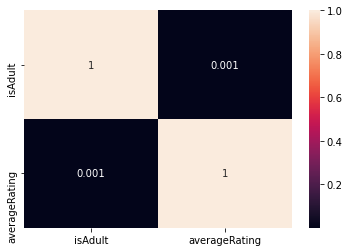

In [24]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = dataset.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()